# 1. Imports & Setup


In [ ]:
import os
import pretty_midi
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim import Adam
import pandas as pd
import re
from gensim.models import Word2Vec
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, Dataset

# 2. Preprocessing Functions


In [ ]:
def process_lyrics_set(path):
    columns = ["artist", "song_1", "lyrics_1", "song_2", "lyrics_2", "song_3", "lyrics_3"]
    raw_data = pd.read_csv(path, names=columns, header=None)
    processed_data = []
    for _, row in raw_data.iterrows():
        artist = row['artist'].strip()
        songs = [(row['song_1'], row['lyrics_1']),
                 (row['song_2'], row['lyrics_2']) if pd.notna(row['song_2']) else None,
                 (row['song_3'], row['lyrics_3']) if pd.notna(row['song_3']) else None]

        for song in songs:
            if song is not None:
                song_name, lyrics = song
                lyrics = lyrics.strip()
                #tokens = clean_text(lyrics.lower())
                processed_data.append({
                    'artist': artist,
                    'song': song_name.strip(),
                    'lyrics': lyrics,
                    'midi_file': None,
                    'lyric_tokens': None})
    return pd.DataFrame(processed_data)

In [ ]:
def map_midi_files_to_lyrics(df, folder_path):
    """
    Maps MIDI files to rows in a DataFrame containing lyrics based on artist and song names.

    Args:
        df (pd.DataFrame): DataFrame with 'artist' and 'song' columns.
        folder_path (str): Path to the folder containing MIDI files.

    Returns:
        pd.DataFrame: Updated DataFrame with valid MIDI file names in the 'midi_file' column.
    """
    # Iterate through the MIDI files in the specified folder
    for midi_file in os.listdir(folder_path):
        if midi_file.lower().endswith(".mid"):
            parts = midi_file.rsplit("_-_", maxsplit=1) # Extract artist and song names by splitting the filename
            if len(parts) == 2:
                artist, song_with_ext = parts
                artist = artist.lower().replace("_", " ").strip()
                song = song_with_ext.lower().replace("_", " ").replace(".mid", "").strip()

                # Locate matching rows in the DataFrame
                matched_rows = df[
                    (df['artist'].str.lower().str.strip() == artist) &
                    (df['song'].str.lower().str.strip() == song)]

                if not matched_rows.empty:
                    try:
                        # Validate the MIDI file with PrettyMIDI
                        midi_path = os.path.join(folder_path, midi_file)
                        pretty_midi.PrettyMIDI(midi_path)

                        # Update the DataFrame for all matched rows
                        df.loc[matched_rows.index, 'midi_file'] = midi_file
                    except Exception as e:
                        print(f"Error reading MIDI file {midi_file}: {e}")
    df = df[df['midi_file'].notna()].reset_index(drop=True) # Drop rows where 'midi_file' is NaN or None
    return df

In [ ]:
def replace_contractions(text):
    # Patterns to replace contractions with their expanded forms
    patterns = {
        r"\bdon't\b": "do not", r"\bdoesn't\b": "does not",
        r"\bdidn't\b": "did not", r"\bcan't\b": "can not",
        r"\bcouldn't\b": "could not", r"\bshouldn't\b": "should not",
        r"\bwouldn't\b": "would not", r"\bwon't\b": "will not",
        r"\baren't\b": "are not", r"\bweren't\b": "were not",
        r"\bhasn't\b": "has not", r"\bhaven't\b": "have not",
        r"\bhadn't\b": "had not", r"\bmustn't\b": "must not",
        r"\bi'm\b": "i am", r"\byou're\b": "you are",
        r"\bhe's\b": "he is", r"\bshe's\b": "she is",
        r"\bit's\b": "it is", r"\bwe're\b": "we are",
        r"\bthey're\b": "they are", r"\bi've\b": "i have",
        r"\byou've\b": "you have", r"\bwe've\b": "we have",
        r"\bthey've\b": "they have", r"\bi'd\b": "i would",
        r"\byou'd\b": "you would", r"\bhe'd\b": "he would",
        r"\bshe'd\b": "she would", r"\bit'd\b": "it would",
        r"\bwe'd\b": "we would", r"\bthey'd\b": "they would",
        r"\bi'll\b": "I will", r"\byou'll\b": "you will",
        r"\bhe'll\b": "he will", r"\bshe'll\b": "she will",
        r"\bit'll\b": "it will", r"\bwe'll\b": "we will",
        r"\bthey'll\b": "they will"
    }
    for pattern, replacement in patterns.items():
        text = re.sub(pattern, replacement, text)
    return text

In [ ]:
def clean_and_tokenize_lyrics(text):
    text = replace_contractions(text) # Replace contractions and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove non-alphabetic characters (except spaces)
    words = text.split() # Split the text into individual words
    words = [word for word in words if word] # Filter out unwanted symbols
    return words

In [ ]:
def update_lyric_tokens(df):
    for index, row in df.iterrows(): # Iterate over each row in the DataFrame
        lyrics = row['lyrics'].lower().strip() # Get the lyrics text and clean it
        tokens = clean_and_tokenize_lyrics(lyrics)
        df.at[index, 'lyric_tokens'] = tokens # Assign the tokens to the 'lyric_token' column
    return df

# 3. Load & Explore Data


In [ ]:
train_path =  "/home/nicoleka/DL-Ass3/lyrics_train_set.csv"
test_path = "/home/nicoleka/DL-Ass3/lyrics_test_set.csv"
folder_path = "/home/nicoleka/DL-Ass3/midi_files"


train_df = process_lyrics_set(train_path)
train_df = map_midi_files_to_lyrics(train_df, folder_path)
train_df = update_lyric_tokens(train_df)


test_df = process_lyrics_set(test_path)
test_df = map_midi_files_to_lyrics(test_df, folder_path)
test_df = update_lyric_tokens(test_df)


train_set, val_set = train_test_split(train_df, test_size=0.1, random_state=42)

/home/nicoleka/myenv/lib64/python3.9/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error reading MIDI file David_Bowie_-_Lazarus.mid: Could not decode key with 16 sharps and mode 1
Error reading MIDI file Beastie_Boys_-_Girls.mid: Could not decode key with 1 flats and mode 255
Error reading MIDI file Aaron_Neville_-_Tell_It_Like_It_Is.mid: data byte must be in range 0..127
Error reading MIDI file Brian_McKnight_-_On_The_Down_Low.mid: 
Error reading MIDI file Billy_Joel_-_Movin'_Out.mid: data byte must be in range 0..127
Error reading MIDI file Dan_Fogelberg_-_Leader_of_the_Band.mid: Could not decode key with 4 flats and mode 255
Error reading MIDI file Billy_Joel_-_Pressure.mid: data byte must be in range 0..127


In [ ]:
train_df

,artist,song,lyrics,midi_file,lyric_tokens
0,elton john,candle in the wind,goodbye norma jean & though i never knew you a...,Elton_John_-_Candle_in_the_Wind.mid,"[goodbye, norma, jean, though, i, never, knew,..."
1,gerry rafferty,baker street,winding your way down on baker street & lite i...,Gerry_Rafferty_-_Baker_Street.mid,"[winding, your, way, down, on, baker, street, ..."
2,gerry rafferty,right down the line,you know i need your love & you've got that ho...,Gerry_Rafferty_-_Right_Down_the_Line.mid,"[you, know, i, need, your, love, you, have, go..."
3,2 unlimited,tribal dance,come on check it out ya'll & (come on come on!...,2_Unlimited_-_Tribal_Dance.mid,"[come, on, check, it, out, yall, come, on, com..."
4,2 unlimited,let the beat control your body,let the beat control your body & let the beat ...,2_Unlimited_-_Let_the_Beat_Control_Your_Body.mid,"[let, the, beat, control, your, body, let, the..."
...,...,...,...,...,...
596,don henley,dirty laundry,i make my living off the evening news & just g...,Don_Henley_-_Dirty_Laundry.mid,"[i, make, my, living, off, the, evening, news,..."
597,don henley,new york minute,harry got up & dressed all in black & went dow...,Don_Henley_-_New_York_Minute.mid,"[harry, got, up, dressed, all, in, black, went..."
598,bob dylan,subterranean homesick blues,johnny's in the basement & mixing up the medic...,Bob_Dylan_-_Subterranean_Homesick_Blues.mid,"[johnnys, in, the, basement, mixing, up, the, ..."
599,goldfinger,mable,i met her sunday that was yesterday & the girl...,Goldfinger_-_Mable.mid,"[i, met, her, sunday, that, was, yesterday, th..."


# 4. Exploratory Data Analysis

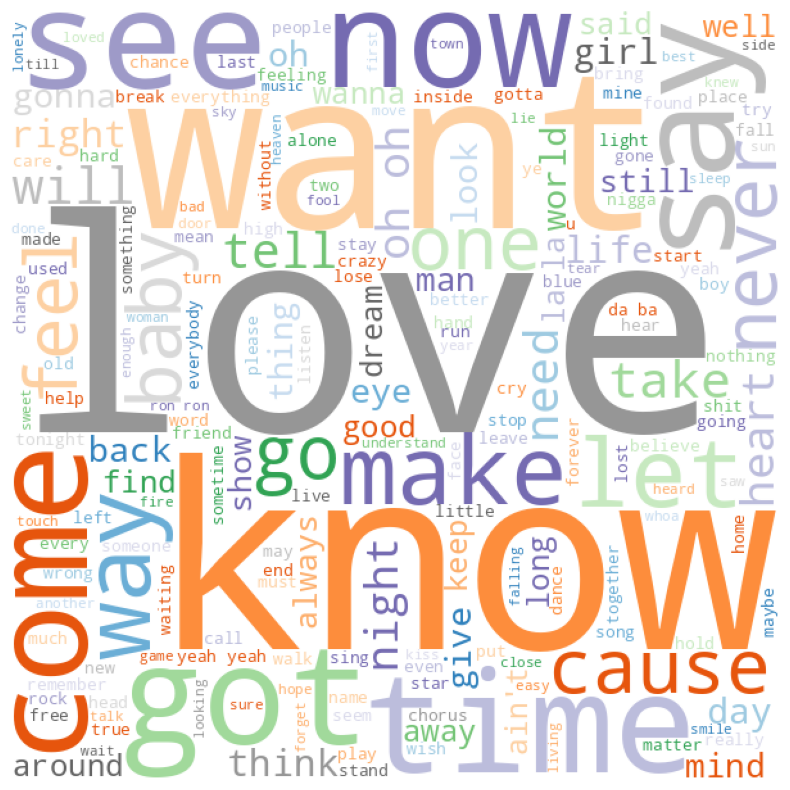

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

wordcloud = WordCloud(width = 600, height = 600, background_color ='white', colormap='tab20c',
                min_font_size = 10).generate(" ".join(lyrics for lyrics in train_df.lyrics))


plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
def collect_all_tokens(*dfs):
    all_tokens = []
    for df in dfs:
        all_tokens.extend(df['lyric_tokens'].tolist())
    return all_tokens

In [ ]:
# Function to map tokens to embeddings
def map_tokens_to_embeddings(df, word2vec_model):
    token_to_embedding = {}
    for tokens in df['lyric_tokens']:
        for token in tokens:
            if token in word2vec_model.wv:
                token_to_embedding[token] = word2vec_model.wv[token]

    df['token_embeddings'] = df['lyric_tokens'].apply(lambda tokens: [token_to_embedding[token] for token in tokens if token in token_to_embedding])
    return df

In [ ]:
all_tokens = collect_all_tokens(train_set, val_set, test_df)

word2vec_model = Word2Vec(sentences=all_tokens, vector_size=300, window=5, min_count=1, sg=0)

# Map tokens to embeddings for each set
train_set = map_tokens_to_embeddings(train_set, word2vec_model)
val_set = map_tokens_to_embeddings(val_set, word2vec_model)
test_set = map_tokens_to_embeddings(test_df, word2vec_model)

# 5. Feature Extraction

In [ ]:
def process_midi_file(midi_file, num_words, folder_path):
    """
    Processes a MIDI file to extract its features, including piano roll and chroma, for each word.

    Args:
        midi_file (str): The name of the MIDI file.
        num_words (int): The number of words in the corresponding lyric token list.
        folder_path (str): The path to the folder containing the MIDI files.

    Returns:
        np.ndarray: A 2D array of features for each word, including piano roll and optional chroma summary.
    """
    try:
        # Load the MIDI file
        midi_path = os.path.join(folder_path, midi_file)
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        midi_data.remove_invalid_notes()

        # Extract piano roll and count active notes
        piano_roll = midi_data.get_piano_roll(fs=5)
        active_note_counts = (piano_roll > 0).astype(int).sum(axis=0)
        active_note_counts[active_note_counts == 0] = 1  # Avoid division by zero

        # Normalize the piano roll
        normalized_piano_roll = piano_roll.sum(axis=0) / active_note_counts

        # Filter out the non-zero part of the piano roll
        valid_start = (normalized_piano_roll > 0).argmax()  # First non-zero frame
        valid_piano_roll = normalized_piano_roll[valid_start:]
        # valid_chroma = chroma[:, valid_start:]

        # Calculate per-word features using sliding windows
        stride = len(valid_piano_roll) // (num_words + 1)  # Dynamic stride based on melody length
        features = np.zeros((num_words, 4))  #  4 piano roll
        # print(f"Features shape for {midi_file}: {features.shape}")

        for i in range(num_words):
            start = i * stride
            end = min(start + stride, len(valid_piano_roll))

            # Piano roll features (mean, std, max, min)
            segment = valid_piano_roll[start:end]
            features[i, :4] = [
                segment.mean() if len(segment) > 0 else 0,
                segment.std() if len(segment) > 0 else 0,
                segment.max() if len(segment) > 0 else 0,
                segment.min() if len(segment) > 0 else 0,
            ]

        # Replace NaNs with small default values
        features = np.nan_to_num(features, nan=0.001)
        return features

    except Exception as e:
        print(f"Error processing {midi_file}: {e}")
        return np.zeros((num_words, 4))  # Default shape for failed cases

In [ ]:
def extract_midi_features(df, folder_path):
    """
    Extracts MIDI features for each MIDI file in the DataFrame and adds them as a new column.

    Args:
        df (pandas.DataFrame): The input DataFrame containing 'midi_file' and 'lyrics_tokens'.
        folder_path (str): Path to the folder containing the MIDI files.

    Returns:
        pandas.DataFrame: The modified DataFrame with additional feature columns.
    """
    # Add a new column for the extracted features
    df['midi_features_per_word'] = None

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        num_words = len(row['lyric_tokens'])
        features = process_midi_file(row['midi_file'], num_words, folder_path)
        # print(f"Row {idx}: Features shape - {features.shape}, Num words - {num_words}")
        df.at[idx, 'midi_features_per_word'] = features

    return df

In [ ]:
train_set_per_word = extract_midi_features(train_set, folder_path)
val_set_per_word = extract_midi_features(val_set, folder_path)
test_set_per_word = extract_midi_features(test_set, folder_path)

  0%|          | 0/540 [00:00<?, ?it/s]/home/nicoleka/myenv/lib64/python3.9/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
100%|██████████| 5/5 [00:00<00:00,  8.43it/s]


In [ ]:
def extract_midi_features_general(df, folder_path):
    """
    Extracts general MIDI features from MIDI files and adds them to the DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame containing 'midi_file'.
        folder_path (str): Path to the folder containing the MIDI files.

    Returns:
        pandas.DataFrame: The modified DataFrame with additional feature columns.
    """
    def process_midi_file(midi_file):
        try:
            # Load the MIDI file
            midi_path = os.path.join(folder_path, midi_file)
            midi_data = pretty_midi.PrettyMIDI(midi_path)

            # Extract general tempo features
            tempo, _ = midi_data.get_tempo_changes()  # List of tempo changes (bpm)
            estimated_tempo = np.mean(tempo) if len(tempo) > 0 else 0  # Estimated overall tempo

            pitch_class_histogram = midi_data.get_pitch_class_histogram() # Calculate pitch class histogram (distribution of pitch classes)

            # Compute note density (average number of notes per second)
            note_onsets = midi_data.get_onsets()
            note_density = len(note_onsets) / midi_data.get_end_time() if midi_data.get_end_time() > 0 else 0

            # Extract structural features like beats and downbeats
            beats = midi_data.get_beats()  # List of beat times
            downbeats = midi_data.get_downbeats()  # List of downbeat times
            duration = midi_data.get_end_time() # General duration feature (total duration of the piece)

            # Aggregate features into a single vector (all features are scalar values)
            features = [estimated_tempo,
                        np.mean(pitch_class_histogram),  # Mean pitch class distribution
                        note_density,
                        len(beats),  # Number of beats
                        len(downbeats),  # Number of downbeats
                        duration]
            return features

        except Exception as e:
            print(f"Error processing {midi_file}: {e}")
            return [0] * 6  # Default features for failed cases
    df['midi_features_general'] = None # Add a new column for the extracted features

    # Loop through all rows and extract features for each MIDI file
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        features = process_midi_file(row['midi_file'])
        df.at[idx, 'midi_features_general'] = features

    return df

In [ ]:
train_set_general = extract_midi_features_general(train_set, folder_path)
val_set_general = extract_midi_features_general(val_set, folder_path)
test_set_general = extract_midi_features_general(test_set, folder_path)

  0%|          | 0/540 [00:00<?, ?it/s]/home/nicoleka/myenv/lib64/python3.9/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
  0%|          | 0/61 [00:00<?, ?it/s]/home/nicoleka/myenv/lib64/python3.9/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
100%|██████████| 5/5 [00:00<00:00,  9.25it/s]


In [ ]:
all_words_in_corpus = list(word2vec_model.wv.index_to_key)  # List of all words in vocabulary
all_words_in_corpus_size = len(all_words_in_corpus)
all_words_in_corpus_dict = word2vec_model.wv.key_to_index
word_index_map = {value: key for key, value in all_words_in_corpus_dict.items()}

In [ ]:
def split__to_Xy(df):
    X_embedding, X_melody, y = [], [], []

    # Get the word embeddings for each word and the corresponding melody features
    word2vec_embeddings = df['token_embeddings']
    midi_file_features = df['midi_features_per_word']  # Each record has the melody features
    # Iterate over each word embedding and corresponding melody features
    for idx, (embedding, melody_features) in tqdm(enumerate(zip(word2vec_embeddings, midi_file_features))):
        for word_idx, word_vec in enumerate(embedding):

            if word_idx < len(embedding) - 1: # Skip if we are at the last word (no next word to predict)
                if word_idx < len(melody_features): # Ensure there are enough melody features for this word index
                    X_embedding.append(np.array(word_vec)) # Append the current word's embedding and the corresponding melody features
                    X_melody.append(np.array(melody_features[word_idx]))

                    next_word = df.iloc[idx]['lyric_tokens'][word_idx + 1] # Create the target Y: next word's one-hot encoded embedding

                    if next_word in all_words_in_corpus_dict:
                        # Get the one-hot index for the next word
                        y_temp = np.zeros(all_words_in_corpus_size)
                        y_temp[all_words_in_corpus_dict[next_word]] = 1
                        y.append(y_temp)
    # print(X_embedding)
    # print(X_melody)
    # print(y)
    # Convert lists into arrays for LSTM model input
    X_embeddings_arr, X_melody_arr, Y = np.array(X_embedding), np.array(X_melody), np.array(y)

    # Reshaping for LSTM (samples, time_steps, features)
    X_embedding_reshape = X_embeddings_arr.reshape(X_embeddings_arr.shape[0], 1, X_embeddings_arr.shape[1])
    X_melody_reshape = X_melody_arr.reshape(X_melody_arr.shape[0], 1, X_melody_arr.shape[1])
    X = (X_embedding_reshape, X_melody_reshape) # Combine melody and word embeddings as a tuple for the LSTM model

    return X, Y

In [ ]:
train_df_X_per_word, train_df_y_per_word = split__to_Xy(train_set_per_word)
val_df_X_per_word, val_df_y_per_word = split__to_Xy(val_set_per_word)
test_df_X_per_word, test_df_y_per_word = split__to_Xy(test_set_per_word)

540it [00:07, 72.24it/s]
61it [00:00, 75.86it/s]
5it [00:00, 124.77it/s]


In [ ]:
print(type(train_df_X_per_word))  # Should be pd.DataFrame or pd.Series
print(type(train_df_y_per_word))
print(len(train_df_X_per_word))  # Number of elements in the tuple
print(train_df_X_per_word[0].shape)  # Shape of the first element
print(train_df_X_per_word[1].shape)

<class 'tuple'>
<class 'numpy.ndarray'>
2
(142819, 1, 300)
(142819, 1, 4)


# 6. Model: Word‐level Melody


In [ ]:
class LSTMModelMelodyPerWord(nn.Module):
    def __init__(self, midi_features_vector_size=4, max_num_of_words=7485, dropout=0.2):
        super(LSTMModelMelodyPerWord, self).__init__()

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=300 + midi_features_vector_size, hidden_size=32, batch_first=True, dropout=dropout)
        self.lstm2 = nn.LSTM(input_size=32, hidden_size=64, batch_first=True, dropout=dropout)

        # Fully connected layers
        self.fc1 = nn.Linear(64, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, max_num_of_words)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_word_embedding, input_midi_features):
        # Concatenate inputs along feature dimension
        concatenated_input = torch.cat([input_word_embedding, input_midi_features], dim=2)

        # LSTM layers
        lstm_out, _ = self.lstm1(concatenated_input)
        lstm_out, _ = self.lstm2(lstm_out)

        # Fully connected layers
        fc_out = self.fc1(lstm_out[:, -1, :])  # Use the last timestep output
        fc_out = self.relu(fc_out)
        fc_out = self.dropout(fc_out)
        # output = self.fc2(fc_out)

        # Compute logits and clamp them
        output_logits = self.fc2(fc_out)  # Logits before softmax
        output_logits = torch.clamp(output_logits, min=-3, max=3)  # Clamp to stabilize softmax

        scaled_logits = output_logits / 0.8

        # Apply softmax to get probabilities
        return scaled_logits

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

def train_model_per_word(model, train_loader, val_loader, epochs=50, lr=0.01, loss_fn=nn.CrossEntropyLoss(), log_dir="/home/nicoleka/DL-Ass3/tensorboard_logs-word"):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    writer = SummaryWriter(log_dir)  # Initialize TensorBoard writer
    best_val_loss = float('inf')
    patience_counter = 0
    max_patience = 3  # Early stopping patience

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_mse = 0
        train_cosine_sim = 0

        for batch in train_loader:
            word_embeddings, midi_features, labels = batch
            word_embeddings = word_embeddings.to(device)
            midi_features = midi_features.to(device)
            labels = labels.to(device)

            if labels.ndim > 1:
                labels = torch.argmax(labels, dim=1)

            optimizer.zero_grad()
            outputs = model(word_embeddings, midi_features)
            loss = loss_fn(outputs, labels)
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()

            # Compute additional metrics (MSE and Cosine Similarity)
            probs = F.softmax(outputs, dim=-1)
            train_mse += F.mse_loss(probs, F.one_hot(labels, num_classes=probs.shape[-1]).float()).item()
            train_cosine_sim += F.cosine_similarity(probs, F.one_hot(labels, num_classes=probs.shape[-1]).float(), dim=-1).mean().item()

        train_loss /= len(train_loader)
        train_mse /= len(train_loader)
        train_cosine_sim /= len(train_loader)

        # Log training metrics to TensorBoard
        writer.add_scalar("Loss/Train", train_loss, epoch + 1)
        writer.add_scalar("MSE/Train", train_mse, epoch + 1)
        writer.add_scalar("CosineSimilarity/Train", train_cosine_sim, epoch + 1)

        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss:.4f}, "
              f"Training MSE: {train_mse:.4f}, Training Cosine Similarity: {train_cosine_sim:.4f}")

        model.eval()
        val_loss = 0
        val_mse = 0
        val_cosine_sim = 0

        with torch.no_grad():
            for batch in val_loader:
                word_embeddings, midi_features, labels = batch
                word_embeddings = word_embeddings.to(device)
                midi_features = midi_features.to(device)
                labels = labels.to(device)

                if labels.ndim > 1:
                    labels = torch.argmax(labels, dim=1)

                outputs = model(word_embeddings, midi_features)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                # Compute additional metrics (MSE and Cosine Similarity)
                probs = F.softmax(outputs, dim=-1)
                val_mse += F.mse_loss(probs, F.one_hot(labels, num_classes=probs.shape[-1]).float()).item()
                val_cosine_sim += F.cosine_similarity(probs, F.one_hot(labels, num_classes=probs.shape[-1]).float(), dim=-1).mean().item()

            val_loss /= len(val_loader)
            val_mse /= len(val_loader)
            val_cosine_sim /= len(val_loader)

            # Log validation metrics to TensorBoard
            writer.add_scalar("Loss/Validation", val_loss, epoch + 1)
            writer.add_scalar("MSE/Validation", val_mse, epoch + 1)
            writer.add_scalar("CosineSimilarity/Validation", val_cosine_sim, epoch + 1)

            print(f"Validation Loss: {val_loss:.4f}, Validation MSE: {val_mse:.4f}, "
                  f"Validation Cosine Similarity: {val_cosine_sim:.4f}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience
        else:
            patience_counter += 1
            if patience_counter >= max_patience:
                print("Early stopping triggered.")
                break

    print("Training completed.")
    writer.close()  # Close the TensorBoard writer
    return model

2025-01-17 20:50:30.622194: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737139831.217455  800676 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737139831.441215  800676 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 20:50:33.808019: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
def predict_per_word(model, single_song, num_words_to_predict=50, start_word_idx=None, w2v_model=None, word_index_map=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    generated_song = []
    word_to_begin = start_word_idx
    if word_to_begin is None:
        word_to_begin = single_song['lyric_tokens'][0]

    for _ in range(num_words_to_predict):
        generated_song.append(word_to_begin)
        word_embedding = w2v_model[word_to_begin]  # Replace with actual embedding retrieval
        midi_feature = single_song['midi_features_per_word'][_]

        # Convert word embedding and MIDI feature to tensors
        word_embedding_tensor = torch.tensor(word_embedding, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        midi_feature_tensor = torch.tensor(midi_feature, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

        # Get raw logits from the model
        output_logits = model(word_embedding_tensor, midi_feature_tensor)
        output_logits = output_logits.squeeze(0)  # Remove batch dimension

        # Apply softmax to convert logits to probabilities
        output_probs = F.softmax(output_logits, dim=-1).cpu().detach().numpy()

        # Select a word index based on the probabilities
        next_word_idx = np.random.choice(len(output_probs), p=output_probs)
        word_to_begin = word_index_map[next_word_idx]

    return generated_song


In [ ]:
model_melody_per_word = LSTMModelMelodyPerWord(max_num_of_words=all_words_in_corpus_size)

/home/nicoleka/myenv/lib64/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Convert data to tensors
train_X_word_embeddings_word = torch.tensor(train_df_X_per_word[0], dtype=torch.float32)
train_X_midi_features_word = torch.tensor(train_df_X_per_word[1], dtype=torch.float32)
train_Y_word = torch.tensor(train_df_y_per_word, dtype=torch.long)  # Assuming labels are indices for classes

val_X_word_embeddings_word = torch.tensor(val_df_X_per_word[0], dtype=torch.float32)
val_X_midi_features_word = torch.tensor(val_df_X_per_word[1], dtype=torch.float32)
val_Y_word = torch.tensor(val_df_y_per_word, dtype=torch.long)

# Create TensorDataset and DataLoader
train_dataset_word  = TensorDataset(train_X_word_embeddings_word, train_X_midi_features_word, train_Y_word)
val_dataset_word  = TensorDataset(val_X_word_embeddings_word, val_X_midi_features_word, val_Y_word)

train_loader_per_word = DataLoader(train_dataset_word , batch_size=32, shuffle=True)
val_loader_per_word = DataLoader(val_dataset_word , batch_size=32, shuffle=False)

In [ ]:
trained_model_word = train_model_per_word(
    model=model_melody_per_word,
    train_loader=train_loader_per_word,
    val_loader=val_loader_per_word,
    epochs=20,
    lr=0.001
)

Epoch 1/20, Training Loss: 6.2751, Training MSE: 0.0001, Training Cosine Similarity: 0.1008
Validation Loss: 6.3546, Validation MSE: 0.0001, Validation Cosine Similarity: 0.1008
Epoch 2/20, Training Loss: 6.0368, Training MSE: 0.0001, Training Cosine Similarity: 0.1149
Validation Loss: 6.2457, Validation MSE: 0.0001, Validation Cosine Similarity: 0.1116
Epoch 3/20, Training Loss: 5.9378, Training MSE: 0.0001, Training Cosine Similarity: 0.1238
Validation Loss: 6.2051, Validation MSE: 0.0001, Validation Cosine Similarity: 0.1140
Epoch 4/20, Training Loss: 5.8692, Training MSE: 0.0001, Training Cosine Similarity: 0.1297
Validation Loss: 6.1446, Validation MSE: 0.0001, Validation Cosine Similarity: 0.1234
Epoch 5/20, Training Loss: 5.8173, Training MSE: 0.0001, Training Cosine Similarity: 0.1338
Validation Loss: 6.1024, Validation MSE: 0.0001, Validation Cosine Similarity: 0.1278
Epoch 6/20, Training Loss: 5.7761, Training MSE: 0.0001, Training Cosine Similarity: 0.1375
Validation Loss: 6

In [ ]:
for word in ['original_word', 'hello', 'love', 'morning']:
    for i in range (0, len(test_set_general)):

        single_song_df = test_set_general.iloc[i]

        if word == "original_word":
            word = single_song_df['lyric_tokens'][0]
            generated_song_lyrics = predict_per_word(
                model=trained_model_word,
                single_song=single_song_df,
                num_words_to_predict=50,
                w2v_model=word2vec_model.wv,
                word_index_map=word_index_map
            )

        else:
            generated_song_lyrics = predict_per_word(
                model=trained_model_word,
                single_song=single_song_df,
                num_words_to_predict=50,
                song_word = word,
                w2v_model=word2vec_model.wv,
                word_index_map=word_index_map
            )

        print(f'Predicted lyrics for {single_song_df["song"]} using LSTMModelMelodyPerword network, starting with the word {word}:\n')
        # print song lyrics
        for i in range(0, len(generated_song_lyrics), 5):
            print(" ".join(generated_song_lyrics[i:i+5]))
        print("\n")


Model per song

In [ ]:
def split_df_to_X_y(df):
    X_embedding, X_melody, y = [], [], []

    # Get the word embeddings for each word and the corresponding melody features
    word2vec_embeddings = df['token_embeddings']
    midi_file_features = df['midi_features_general']  # Each record has the melody features

    # Iterate over each word embedding and corresponding melody features
    for idx, (embedding, melody_features) in tqdm(enumerate(zip(word2vec_embeddings, midi_file_features))):
        for word_idx, word_vec in enumerate(embedding):
            # Skip if we are at the last word (no next word to predict)
            if word_idx < len(embedding) - 1:
                # Append the current word's embedding and the entire melody feature sequence
                X_embedding.append(np.array(word_vec))
                X_melody.append(np.array(melody_features))

                # Create the target Y: next word's one-hot encoded embedding
                next_word = df.iloc[idx]['lyric_tokens'][word_idx + 1]

                if next_word in all_words_in_corpus_dict:
                    # Get the one-hot index for the next word
                    y_temp = np.zeros(all_words_in_corpus_size)
                    y_temp[all_words_in_corpus_dict[next_word]] = 1
                    y.append(y_temp)

    # Convert lists into arrays for LSTM model input
    X_embeddings_arr = np.array(X_embedding)
    X_melody_arr = np.array(X_melody)

    # Reshaping for LSTM (samples, time_steps, features)
    X_embedding_reshape = X_embeddings_arr.reshape(X_embeddings_arr.shape[0], 1, X_embeddings_arr.shape[1])
    X_melody_reshape = X_melody_arr.reshape(X_melody_arr.shape[0], 1, X_melody_arr.shape[1])

    # Combine melody and word embeddings as a tuple for the LSTM model
    X = (X_embedding_reshape, X_melody_reshape)
    Y = np.array(y)

    return X, Y


In [ ]:
train_df_X_general, train_df_y_general = split_df_to_X_y(train_set_general)
val_df_X_general, val_df_y_general = split_df_to_X_y(val_set_general)
test_df_X_general, test_df_y_general = split_df_to_X_y(test_set_general)

540it [00:23, 22.73it/s]
61it [00:00, 80.29it/s]
5it [00:00, 143.33it/s]


In [ ]:
print(type(train_df_X_general))  # Should be pd.DataFrame or pd.Series
print(type(train_df_y_general))
print(len(train_df_X_general))  # Number of elements in the tuple
print(train_df_X_general[0].shape)  # Shape of the first element
print(train_df_X_general[1].shape)

<class 'tuple'>
<class 'numpy.ndarray'>
2
(142819, 1, 300)
(142819, 1, 6)


# 7. Model: Song‐level Melody

In [ ]:
class LSTMModelMelodyPerSong(nn.Module):
    def __init__(self, midi_features_vector_size=6, max_num_of_words=7485, dropout=0.2):
        super(LSTMModelMelodyPerSong, self).__init__()

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=300 + midi_features_vector_size, hidden_size=32, batch_first=True, dropout=dropout)
        self.lstm2 = nn.LSTM(input_size=32, hidden_size=64, batch_first=True, dropout=dropout)

        # Fully connected layers
        self.fc1 = nn.Linear(64, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, max_num_of_words)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_word_embedding, input_midi_features):
        # Concatenate inputs along feature dimension
        concatenated_input = torch.cat([input_word_embedding, input_midi_features], dim=2)

        # LSTM layers
        lstm_out, _ = self.lstm1(concatenated_input)
        lstm_out, _ = self.lstm2(lstm_out)

        # Fully connected layers
        fc_out = self.fc1(lstm_out[:, -1, :])  # Use the last timestep output
        fc_out = self.relu(fc_out)
        fc_out = self.dropout(fc_out)
        # output = self.fc2(fc_out)

        # Compute logits and clamp them
        output_logits = self.fc2(fc_out)  # Logits before softmax
        output_logits = torch.clamp(output_logits, min=-3, max=3)  # Clamp to stabilize softmax

        scaled_logits = output_logits / 0.8

        # Apply softmax to get probabilities
        return scaled_logits

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

def train_model_per_song(model, train_loader, val_loader, epochs=50, lr=0.01, loss_fn=nn.CrossEntropyLoss(), log_dir="/home/nicoleka/DL-Ass3/tensorboard_logs-song"):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    writer = SummaryWriter(log_dir)  # Initialize TensorBoard writer
    best_val_loss = float('inf')
    patience_counter = 0
    max_patience = 3  # Early stopping patience

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_mse = 0
        train_cosine_sim = 0

        for batch in train_loader:
            word_embeddings, midi_features, labels = batch
            word_embeddings = word_embeddings.to(device)
            midi_features = midi_features.to(device)
            labels = labels.to(device)

            if labels.ndim > 1:
                labels = torch.argmax(labels, dim=1)

            optimizer.zero_grad()
            outputs = model(word_embeddings, midi_features)
            loss = loss_fn(outputs, labels)
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()

            # Compute additional metrics (MSE and Cosine Similarity)
            probs = F.softmax(outputs, dim=-1)
            train_mse += F.mse_loss(probs, F.one_hot(labels, num_classes=probs.shape[-1]).float()).item()
            train_cosine_sim += F.cosine_similarity(probs, F.one_hot(labels, num_classes=probs.shape[-1]).float(), dim=-1).mean().item()

        train_loss /= len(train_loader)
        train_mse /= len(train_loader)
        train_cosine_sim /= len(train_loader)

        # Log training metrics to TensorBoard
        writer.add_scalar("Loss/Train", train_loss, epoch + 1)
        writer.add_scalar("MSE/Train", train_mse, epoch + 1)
        writer.add_scalar("CosineSimilarity/Train", train_cosine_sim, epoch + 1)

        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss:.4f}, "
              f"Training MSE: {train_mse:.4f}, Training Cosine Similarity: {train_cosine_sim:.4f}")

        model.eval()
        val_loss = 0
        val_mse = 0
        val_cosine_sim = 0

        with torch.no_grad():
            for batch in val_loader:
                word_embeddings, midi_features, labels = batch
                word_embeddings = word_embeddings.to(device)
                midi_features = midi_features.to(device)
                labels = labels.to(device)

                if labels.ndim > 1:
                    labels = torch.argmax(labels, dim=1)

                outputs = model(word_embeddings, midi_features)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                # Compute additional metrics (MSE and Cosine Similarity)
                probs = F.softmax(outputs, dim=-1)
                val_mse += F.mse_loss(probs, F.one_hot(labels, num_classes=probs.shape[-1]).float()).item()
                val_cosine_sim += F.cosine_similarity(probs, F.one_hot(labels, num_classes=probs.shape[-1]).float(), dim=-1).mean().item()

            val_loss /= len(val_loader)
            val_mse /= len(val_loader)
            val_cosine_sim /= len(val_loader)

            # Log validation metrics to TensorBoard
            writer.add_scalar("Loss/Validation", val_loss, epoch + 1)
            writer.add_scalar("MSE/Validation", val_mse, epoch + 1)
            writer.add_scalar("CosineSimilarity/Validation", val_cosine_sim, epoch + 1)

            print(f"Validation Loss: {val_loss:.4f}, Validation MSE: {val_mse:.4f}, "
                  f"Validation Cosine Similarity: {val_cosine_sim:.4f}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience
        else:
            patience_counter += 1
            if patience_counter >= max_patience:
                print("Early stopping triggered.")
                break

    print("Training completed.")
    writer.close()  # Close the TensorBoard writer
    return model

In [ ]:
def predict_per_song(model, single_song, num_words_to_predict=50, song_word=None, w2v_model=None, word_index_map=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    generated_song = []
    word_to_begin = song_word
    if word_to_begin is None:
        word_to_begin = single_song['lyric_tokens'][0]

    for _ in range(num_words_to_predict):
        generated_song.append(word_to_begin)
        word_embedding = w2v_model[word_to_begin]  # Replace with actual embedding retrieval
        midi_feature = single_song['midi_features_general']

        # Convert word embedding and MIDI feature to tensors
        word_embedding_tensor = torch.tensor(word_embedding, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        midi_feature_tensor = torch.tensor(midi_feature, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

        # Get raw logits from the model
        output_logits = model(word_embedding_tensor, midi_feature_tensor)
        output_logits = output_logits.squeeze(0)  # Remove batch dimension

        # Apply softmax to convert logits to probabilities
        output_probs = F.softmax(output_logits, dim=-1).cpu().detach().numpy()

        # Select a word index based on the probabilities
        next_word_idx = np.random.choice(len(output_probs), p=output_probs)
        word_to_begin = word_index_map[next_word_idx]

    return generated_song

In [ ]:
model_melody_per_song = LSTMModelMelodyPerSong(max_num_of_words = all_words_in_corpus_size)

/home/nicoleka/myenv/lib64/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [ ]:
# Convert data to tensors
train_X_word_embeddings_song = torch.tensor(train_df_X_general[0], dtype=torch.float32)
train_X_midi_features_song = torch.tensor(train_df_X_general[1], dtype=torch.float32)
train_Y_song = torch.tensor(train_df_y_general, dtype=torch.long)  # Assuming labels are indices for classes

val_X_word_embeddings_song = torch.tensor(val_df_X_general[0], dtype=torch.float32)
val_X_midi_features_song = torch.tensor(val_df_X_general[1], dtype=torch.float32)
val_Y_song = torch.tensor(val_df_y_general, dtype=torch.long)

# Create TensorDataset and DataLoader
train_dataset_song = TensorDataset(train_X_word_embeddings_song, train_X_midi_features_song, train_Y_song)
val_dataset_song = TensorDataset(val_X_word_embeddings_song, val_X_midi_features_song, val_Y_song)

train_loader_per_song = DataLoader(train_dataset_song, batch_size=32, shuffle=True)
val_loader_per_song = DataLoader(val_dataset_song, batch_size=32, shuffle=False)

In [ ]:
trained_model_song = train_model_per_song(
    model=model_melody_per_song,
    train_loader=train_loader_per_song,
    val_loader=val_loader_per_song,
    epochs=20,
    lr=0.001
)

Epoch 1/20, Training Loss: 6.3334, Training MSE: 0.0001, Training Cosine Similarity: 0.0985
Validation Loss: 6.4171, Validation MSE: 0.0001, Validation Cosine Similarity: 0.0981
Epoch 2/20, Training Loss: 6.1123, Training MSE: 0.0001, Training Cosine Similarity: 0.1087
Validation Loss: 6.3277, Validation MSE: 0.0001, Validation Cosine Similarity: 0.1033
Epoch 3/20, Training Loss: 6.0300, Training MSE: 0.0001, Training Cosine Similarity: 0.1146
Validation Loss: 6.2666, Validation MSE: 0.0001, Validation Cosine Similarity: 0.1097
Epoch 4/20, Training Loss: 5.9647, Training MSE: 0.0001, Training Cosine Similarity: 0.1209
Validation Loss: 6.2089, Validation MSE: 0.0001, Validation Cosine Similarity: 0.1156
Epoch 5/20, Training Loss: 5.9222, Training MSE: 0.0001, Training Cosine Similarity: 0.1241
Validation Loss: 6.1791, Validation MSE: 0.0001, Validation Cosine Similarity: 0.1181
Epoch 6/20, Training Loss: 5.8862, Training MSE: 0.0001, Training Cosine Similarity: 0.1265
Validation Loss: 6

In [ ]:

for word in ['original_word', 'hello', 'love', 'morning']:
    for i in range (0, len(test_set_general)):

        single_song_df = test_set_general.iloc[i]

        if word == "original_word":
            generated_song_lyrics = predict_per_song(
                model=trained_model_song,
                single_song=single_song_df,
                num_words_to_predict=50,
                w2v_model=word2vec_model.wv,
                word_index_map=word_index_map
            )

        else:
            generated_song_lyrics = predict_per_song(
                model=trained_model_song,
                single_song=single_song_df,
                num_words_to_predict=50,
                song_word = word
                w2v_model=word2vec_model.wv,
                word_index_map=word_index_map
            )

        print(f'Predicted lyrics for {single_song_df["song"]} using LSTMModelMelodyPerSong network:\n')
        # print song lyrics
        for i in range(0, len(generated_song_lyrics), 5):
            print(" ".join(generated_song_lyrics[i:i+5]))
        print("\n")


close fred then suelo have
the crews she the merely
was stuff and age to
really if the beer forever
money shining of mc lessons
their baby it also twilight
if about swallow you show
but is goin and that
need try me ye stars
even glue rack symbol of
